In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.utils import resample, shuffle

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
plt.rcParams.update({
    'text.usetex':False
})
import seaborn as sns

## Loading the dataset, pre-processing, and analysing the data

In [22]:
cohort_data = pd.read_csv('cohort_data_new.csv')
cohort_data

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,...,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
0,217177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.700000,...,NaN,NaN,13.600000,NaN,13.6,13.6,67,M,12,1
1,219934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,300,F,14,0
2,291702,13.000000,NaN,13.0,13.0,31.000000,NaN,31.0,31.0,7.200000,...,15.0,15.0,10.000000,NaN,10.0,10.0,45,M,28,0
3,239229,17.000000,NaN,17.0,17.0,32.000000,NaN,32.0,32.0,9.100000,...,27.0,27.0,4.800000,NaN,4.8,4.8,85,M,22,0
4,212881,17.000000,NaN,17.0,17.0,29.000000,NaN,29.0,29.0,8.800000,...,22.0,22.0,15.200000,NaN,15.2,15.2,34,F,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30484,268219,18.473684,3.539254,11.0,27.0,16.552632,5.717197,7.0,24.0,7.582143,...,31.0,126.0,19.989744,12.016125,6.6,45.1,70,F,596,0
30485,223087,13.428571,3.207135,11.0,18.0,28.714286,1.496026,26.0,30.0,8.514286,...,39.0,97.0,5.000000,1.272792,4.1,5.9,300,M,40,0
30486,288516,21.745455,3.378681,16.0,31.0,21.309091,2.602511,13.0,26.0,8.477083,...,34.0,146.0,15.687755,6.906357,8.3,37.7,54,M,939,0
30487,211323,18.972973,5.852286,11.0,31.0,21.621622,5.673287,8.0,33.0,9.229032,...,19.0,104.0,7.058621,2.703373,1.7,12.9,56,M,287,0


In [23]:
# Data available in most of the patients:
# This will drop the patients missing this vital information:
df = cohort_data.dropna(subset=[
    'anion_gap_mean', 'anion_gap_min', 'anion_gap_max', 'anion_gap_sd',
    'bicarbonate_mean', 'bicarbonate_min', 'bicarbonate_max', 'bicarbonate_sd',
    'calcium_total_mean', 'calcium_total_min', 'calcium_total_max', 'calcium_total_sd',
    'chloride_mean', 'chloride_min', 'chloride_max', 'chloride_sd',
    'creatinine_mean', 'creatinine_min', 'creatinine_max', 'creatinine_sd',
    'glucose_mean', 'glucose_min', 'glucose_max', 'glucose_sd',
    'hematocrit_mean', 'hematocrit_min', 'hematocrit_max', 'hematocrit_sd',
    'hemoglobin_mean', 'hemoglobin_min', 'hemoglobin_max', 'hemoglobin_sd',
    'mchc_mean', 'mchc_min', 'mchc_max', 'mchc_sd',
    'mcv_mean', 'mcv_min', 'mcv_max', 'mcv_sd',
    'magnesium_mean', 'magnesium_min', 'magnesium_max', 'magnesium_sd',
    'pt_mean', 'pt_min', 'pt_max', 'pt_sd',
    'phosphate_mean', 'phosphate_min', 'phosphate_max', 'phosphate_sd',
    'platelet_count_mean', 'platelet_count_min', 'platelet_count_max', 'platelet_count_sd',
    'potassium_mean', 'potassium_min', 'potassium_max', 'potassium_sd',
    'rdw_mean', 'rdw_min', 'rdw_max', 'rdw_sd',
    'red_blood_cells_mean', 'red_blood_cells_min', 'red_blood_cells_max', 'red_blood_cells_sd',
    'sodium_mean', 'sodium_min', 'sodium_max', 'sodium_sd',
    'urea_nitrogen_mean', 'urea_nitrogen_min', 'urea_nitrogen_max', 'urea_nitrogen_sd',
    'white_blood_cells_mean', 'white_blood_cells_min', 'white_blood_cells_max', 'white_blood_cells_sd',
    'age',  'gender', 'icu_los_hours', 'target'
    ])

# # Drop sparse columns (missing values for many ICU entries)
df = df.dropna(axis=1, how='any')
df

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,...,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
400,203782,10.000000,2.828427,8.0,12.0,19.000000,0.000000,19.0,19.0,8.000000,...,35.0,35.0,14.450000,0.636396,14.0,14.9,82,M,22,0
401,228783,18.500000,0.707107,18.0,19.0,19.500000,0.707107,19.0,20.0,8.000000,...,68.0,69.0,9.350000,0.070711,9.3,9.4,72,M,27,0
402,254423,17.500000,0.707107,17.0,18.0,26.500000,0.707107,26.0,27.0,9.150000,...,41.0,44.0,9.650000,2.474874,7.9,11.4,82,F,26,0
403,227097,19.333333,2.081666,17.0,21.0,18.666667,1.154701,18.0,20.0,7.500000,...,52.0,57.0,13.000000,0.000000,13.0,13.0,300,F,39,0
404,210259,14.000000,0.000000,14.0,14.0,19.000000,0.000000,19.0,19.0,7.900000,...,22.0,23.0,12.150000,1.909188,10.8,13.5,51,F,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,224190,13.250000,1.258306,12.0,15.0,22.000000,2.160247,20.0,25.0,7.600000,...,26.0,44.0,9.666667,0.450925,9.2,10.1,78,M,34,0
30484,268219,18.473684,3.539254,11.0,27.0,16.552632,5.717197,7.0,24.0,7.582143,...,31.0,126.0,19.989744,12.016125,6.6,45.1,70,F,596,0
30486,288516,21.745455,3.378681,16.0,31.0,21.309091,2.602511,13.0,26.0,8.477083,...,34.0,146.0,15.687755,6.906357,8.3,37.7,54,M,939,0
30487,211323,18.972973,5.852286,11.0,31.0,21.621622,5.673287,8.0,33.0,9.229032,...,19.0,104.0,7.058621,2.703373,1.7,12.9,56,M,287,0


Summary of the filtered data

In [24]:
print(df.info())        # Data types and non-null counts
print(df.describe())    # Summary stats for numeric columns
print(df.describe(include='object')) 

<class 'pandas.core.frame.DataFrame'>
Index: 13964 entries, 400 to 30488
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   icustay_id              13964 non-null  int64  
 1   anion_gap_mean          13964 non-null  float64
 2   anion_gap_sd            13964 non-null  float64
 3   anion_gap_min           13964 non-null  float64
 4   anion_gap_max           13964 non-null  float64
 5   bicarbonate_mean        13964 non-null  float64
 6   bicarbonate_sd          13964 non-null  float64
 7   bicarbonate_min         13964 non-null  float64
 8   bicarbonate_max         13964 non-null  float64
 9   calcium_total_mean      13964 non-null  float64
 10  calcium_total_sd        13964 non-null  float64
 11  calcium_total_min       13964 non-null  float64
 12  calcium_total_max       13964 non-null  float64
 13  chloride_mean           13964 non-null  float64
 14  chloride_sd             13964 non-null  f

In [25]:
df = df.drop('icustay_id', axis=1)
df = df.drop('gender', axis=1)
df

,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,calcium_total_sd,...,urea_nitrogen_sd,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,icu_los_hours,target
400,10.000000,2.828427,8.0,12.0,19.000000,0.000000,19.0,19.0,8.000000,0.141421,...,0.000000,35.0,35.0,14.450000,0.636396,14.0,14.9,82,22,0
401,18.500000,0.707107,18.0,19.0,19.500000,0.707107,19.0,20.0,8.000000,0.000000,...,0.707107,68.0,69.0,9.350000,0.070711,9.3,9.4,72,27,0
402,17.500000,0.707107,17.0,18.0,26.500000,0.707107,26.0,27.0,9.150000,0.070711,...,2.121320,41.0,44.0,9.650000,2.474874,7.9,11.4,82,26,0
403,19.333333,2.081666,17.0,21.0,18.666667,1.154701,18.0,20.0,7.500000,0.141421,...,2.516611,52.0,57.0,13.000000,0.000000,13.0,13.0,300,39,0
404,14.000000,0.000000,14.0,14.0,19.000000,0.000000,19.0,19.0,7.900000,0.000000,...,0.707107,22.0,23.0,12.150000,1.909188,10.8,13.5,51,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,13.250000,1.258306,12.0,15.0,22.000000,2.160247,20.0,25.0,7.600000,0.100000,...,7.745967,26.0,44.0,9.666667,0.450925,9.2,10.1,78,34,0
30484,18.473684,3.539254,11.0,27.0,16.552632,5.717197,7.0,24.0,7.582143,0.432095,...,35.602276,31.0,126.0,19.989744,12.016125,6.6,45.1,70,596,0
30486,21.745455,3.378681,16.0,31.0,21.309091,2.602511,13.0,26.0,8.477083,0.725593,...,36.168359,34.0,146.0,15.687755,6.906357,8.3,37.7,54,939,0
30487,18.972973,5.852286,11.0,31.0,21.621622,5.673287,8.0,33.0,9.229032,1.364354,...,28.036689,19.0,104.0,7.058621,2.703373,1.7,12.9,56,287,0


In [26]:
dataset = np.array(df)
y = np.array(df['target'])
X = np.array(df.drop('target', axis=1))
print(np.shape(dataset))
print(np.shape(X))
print(np.shape(y))

# Random shuffle and split 70-30 into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

print(f'# Readmissions in Train: {np.sum(y_train)}')
print(f'# Readmissions in Test: {np.sum(y_test) }')
print(f'% Readmissions in Train: {np.mean(y_train) * 100}')
print(f'% Readmissions in Test: {np.mean(y_test) * 100}')

(13964, 87)
(13964, 86)
(13964,)
(9774, 86)
(4190, 86)
(9774,)
(4190,)
# Readmissions in Train: 1371
# Readmissions in Test: 501
% Readmissions in Train: 14.027010435850215
% Readmissions in Test: 11.957040572792362


### Logistic Regression without upsampling

In [27]:
# Training the LR 
model = LogisticRegression(max_iter=100_000, verbose=True)
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.8s finished


LogisticRegression(max_iter=100000, verbose=True)

In [28]:
# Inference
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate training error for the vanilla Logistic Regression model
y_train_pred = model.predict(X_train)
train_error = np.mean(y_train_pred != y_train)
print(f"Training error (Vanilla LR): {train_error:.3f}")

# Calculate test error for the vanilla Logistic Regression model
test_error = np.mean(y_pred != y_test)
print(f"Test error (Vanilla LR): {test_error:.3f}")

Training error (Vanilla LR): 0.141
Test error (Vanilla LR): 0.123


Classification Report:

                    precision    recall  f1-score   support

No Readmission (0)       0.88      0.99      0.93      3689
   Readmission (1)       0.26      0.02      0.03       501

          accuracy                           0.88      4190
         macro avg       0.57      0.51      0.48      4190
      weighted avg       0.81      0.88      0.83      4190

AUROC for class 1 (Readmission): 0.683


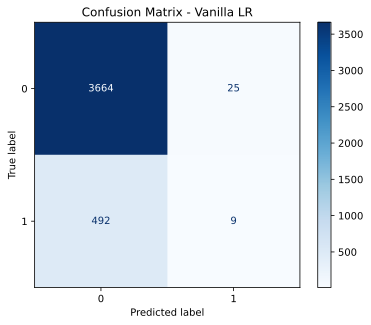

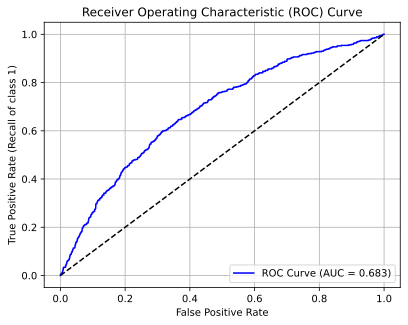

In [29]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Vanilla LR")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Readmission (0)", "Readmission (1)"]))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall of class 1)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
print(f"AUROC for class 1 (Readmission): {roc_auc:.3f}")

#### Logistic Regression with Upsampling

In [30]:
kappa = np.sum(y_train) / (np.shape(X_train)[0] - np.sum(y_train))

x_train_upsampled = np.concatenate([X_train, np.tile(X_train[y_train == 1], (int(1 / kappa) - 1, 1))], axis=0)
y_train_upsampled = np.concatenate([y_train, np.tile(y_train[y_train == 1], int(1 / kappa) - 1)], axis=0)

print("Before balancing:", np.bincount(y_train))
print("After balancing:", np.bincount(y_train_upsampled))

x_train_upsampled, y_train_upsampled = shuffle(x_train_upsampled, y_train_upsampled, random_state=42)

Before balancing: [8403 1371]
After balancing: [8403 8226]


In [31]:
# Normalizing data
scaler = StandardScaler().fit(x_train_upsampled)
x_train_upsampled_normalized = scaler.transform(x_train_upsampled)

model_bal = LogisticRegression(max_iter=100_000)
model_bal.fit(x_train_upsampled_normalized, y_train_upsampled)

X_test_normalized = scaler.transform(X_test)
y_pred_bal = model_bal.predict(X_test_normalized)
y_pred_proba_bal = model_bal.predict_proba(X_test_normalized)[:, 1]

Classification Report (After Upsampling):

                    precision    recall  f1-score   support

No Readmission (0)       0.92      0.70      0.79      3689
   Readmission (1)       0.21      0.58      0.31       501

          accuracy                           0.68      4190
         macro avg       0.57      0.64      0.55      4190
      weighted avg       0.84      0.68      0.74      4190

AUROC after upsampling: 0.685


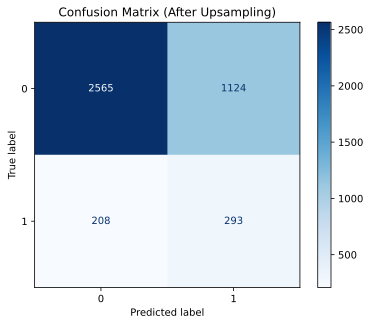

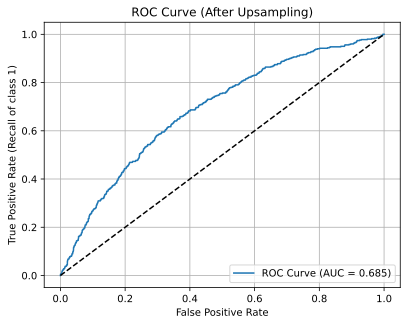

In [32]:
cm_bal = confusion_matrix(y_test, y_pred_bal)
ConfusionMatrixDisplay(cm_bal).plot(cmap='Blues')
plt.title("Confusion Matrix (After Upsampling)")

print("Classification Report (After Upsampling):\n")
print(classification_report(y_test, y_pred_bal, target_names=["No Readmission (0)", "Readmission (1)"]))

# ROC Curve and AUROC
fpr_bal, tpr_bal, _ = roc_curve(y_test, y_pred_proba_bal, pos_label=1)
roc_auc_bal = auc(fpr_bal, tpr_bal)

plt.figure()
plt.plot(fpr_bal, tpr_bal, label=f'ROC Curve (AUC = {roc_auc_bal:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall of class 1)')
plt.title('ROC Curve (After Upsampling)')
plt.legend(loc='lower right')
plt.grid(True)

print(f"AUROC after upsampling: {roc_auc_bal:.3f}")